## Basic SVOL

In [128]:
import pandas as pd
import numpy as np
import pyjags
from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('dark', {'axes.grid' : False})

## Historical data
- Historical data of stock & cryptocurrency prices from [Investing.com](https://www.investing.com/)
- Data ranging from 01-01-2020 to 31-12-2022 i.e. price data of 3 years

In [129]:
# data

df = pd.read_csv('datasets/BAC22.csv')
print(df.shape)
df.head()

(756, 7)


,Date,Price,Open,High,Low,Vol.,Change %
0,12/30/2022,33.12,33.10,33.30,32.86,28.20M,-0.06%
1,12/29/2022,33.14,32.89,33.16,32.75,22.25M,1.13%
2,12/28/2022,32.77,32.57,32.97,32.53,30.54M,0.74%
3,12/27/2022,32.53,32.50,32.67,32.28,22.78M,0.18%
4,12/23/2022,32.47,32.40,32.58,32.19,21.38M,0.25%


In [130]:
df.describe()

,Price,Open,High,Low
count,756.000000,756.000000,756.000000,756.000000
mean,34.624762,34.641283,35.072050,34.191548
std,7.564144,7.584706,7.592191,7.556052
min,18.080000,19.260000,19.670000,17.950000
25%,28.562500,28.667500,28.915000,28.130000
50%,34.790000,34.785000,35.070000,34.455000
75%,40.782500,40.672500,41.152500,40.252500
max,49.380000,49.910000,50.110000,49.030000


In [131]:
'''
  convert string to datetime
  change formats as required for the dates
  '%m/%d/%Y'
  '%b %d, %Y'
'''

df['Date'] = df['Date'].apply(lambda dt: datetime.strptime(dt, "%m/%d/%Y"))

In [132]:
# sorting data chronologically

df.sort_values(by='Date', inplace=True)
df.head(10)

,Date,Price,Open,High,Low,Vol.,Change %
755,2020-01-02,35.64,35.35,35.66,35.29,37.64M,1.19%
754,2020-01-03,34.90,34.98,35.15,34.76,50.76M,-2.08%
753,2020-01-06,34.85,34.41,34.90,34.37,42.23M,-0.14%
752,2020-01-07,34.62,34.70,34.92,34.53,34.35M,-0.66%
751,2020-01-08,34.97,34.57,35.19,34.55,45.34M,1.01%
750,2020-01-09,35.03,35.30,35.33,34.94,39.88M,0.17%
749,2020-01-10,34.74,35.00,35.07,34.66,39.74M,-0.83%
748,2020-01-13,35.06,34.84,35.07,34.66,38.02M,0.92%
747,2020-01-14,35.32,35.30,35.67,35.11,66.79M,0.74%
746,2020-01-15,34.67,34.77,34.79,34.34,74.75M,-1.84%


In [133]:
# get asset returns from closing prices
# yt = 100 * (log(Pt) - log(Pt-1))
df['Asset_return'] = np.log(df['Price'].shift(-1) / df['Price']) * 100
df['Asset_return'] = df['Asset_return'].shift(1)

df[['Asset_return']].head()

,Asset_return
755,NaN
754,-2.098177
753,-0.143369
752,-0.662159
751,1.005900


In [134]:
# have asset returns mean-corrected

ar_mean = df[['Asset_return']].mean()
df['Asset_return'] = df['Asset_return'].apply(lambda a: a - ar_mean)

df[['Asset_return']].mean()

Asset_return   -6.117255e-17
dtype: float64

In [135]:
# asset returns, removing the first NaN
asset_returns = df[['Asset_return']].to_numpy().flatten()[1:]

## Simulated data

## Sampling

In [137]:
# Estimating priors

''' 
  Mean log volatility: mu
  -> take a normal distribution
  -> with mean -> 0 and variance -> variance of logarithmic returns
'''
mean_log_vol = np.mean(np.square(asset_returns))
print(f'Mean log volatility: {mean_log_vol}')

'''
  Persistence of volatility: phi
  -> uniform distribution between 0 to 1
  more complicated models available to estimate the persistence
'''

'''
  Shock scale distribution tends to be heavy-tailed in comparison to the swing in prices itself
  taking a wider normal distribtion
'''
shock = mean_log_vol*2
print(f'Shock: {shock}')


Mean log volatility: 6.7750821363304565
Shock: 13.550164272660913


In [138]:
# sampling configs
CHAINS=2
ITERS=20000
BURN_IN=0

# JAGS sampling
jags_data = {"y": list(asset_returns), "N": len(asset_returns), "mlv": mean_log_vol, "s": shock}
parameters = ['mu', 'phi', 'sigma']
jags_model_string = '''
  model {
    mu ~ dnorm(0, 1/mlv)         # variance is inverse of the precision parameter
    phi ~ dunif(-1, 1)
    sigma ~ dnorm(0, 1/s) T(0,)

    h[1] ~ dnorm(mu, sqrt(1 - pow(phi, 2))/sigma )
    for (i in 2:N) {
      h[i] ~ dnorm(mu + phi * (h[i-1] - mu), 1/sigma)
    }
    
    for (j in 1:N) {
      y[j] ~ dnorm(0, 1/exp(h[j]/2) )
    }
  }
'''
jags_model = pyjags.Model(code=jags_model_string, data=jags_data, chains=CHAINS)
jags_samples = jags_model.sample(iterations=ITERS, vars=parameters)

adapting: iterations 1292 of 2000, elapsed 0:00:05, remaining 0:00:03
adapting: iterations 2000 of 2000, elapsed 0:00:08, remaining 0:00:00
sampling: iterations 2622 of 40000, elapsed 0:00:09, remaining 0:02:04
sampling: iterations 5680 of 40000, elapsed 0:00:18, remaining 0:01:51
sampling: iterations 7224 of 40000, elapsed 0:00:24, remaining 0:01:50
sampling: iterations 10220 of 40000, elapsed 0:00:33, remaining 0:01:36
sampling: iterations 11770 of 40000, elapsed 0:00:39, remaining 0:01:33
sampling: iterations 13288 of 40000, elapsed 0:00:50, remaining 0:01:41
sampling: iterations 15944 of 40000, elapsed 0:00:58, remaining 0:01:28
sampling: iterations 18706 of 40000, elapsed 0:01:06, remaining 0:01:15
sampling: iterations 21570 of 40000, elapsed 0:01:13, remaining 0:01:03
sampling: iterations 24520 of 40000, elapsed 0:01:22, remaining 0:00:52
sampling: iterations 26020 of 40000, elapsed 0:01:28, remaining 0:00:47
sampling: iterations 28978 of 40000, elapsed 0:01:37, remaining 0:00:37

In [141]:
# samples
sample_chains = [jags_samples[p][0] for p in parameters]
colors = ['teal', 'navy']

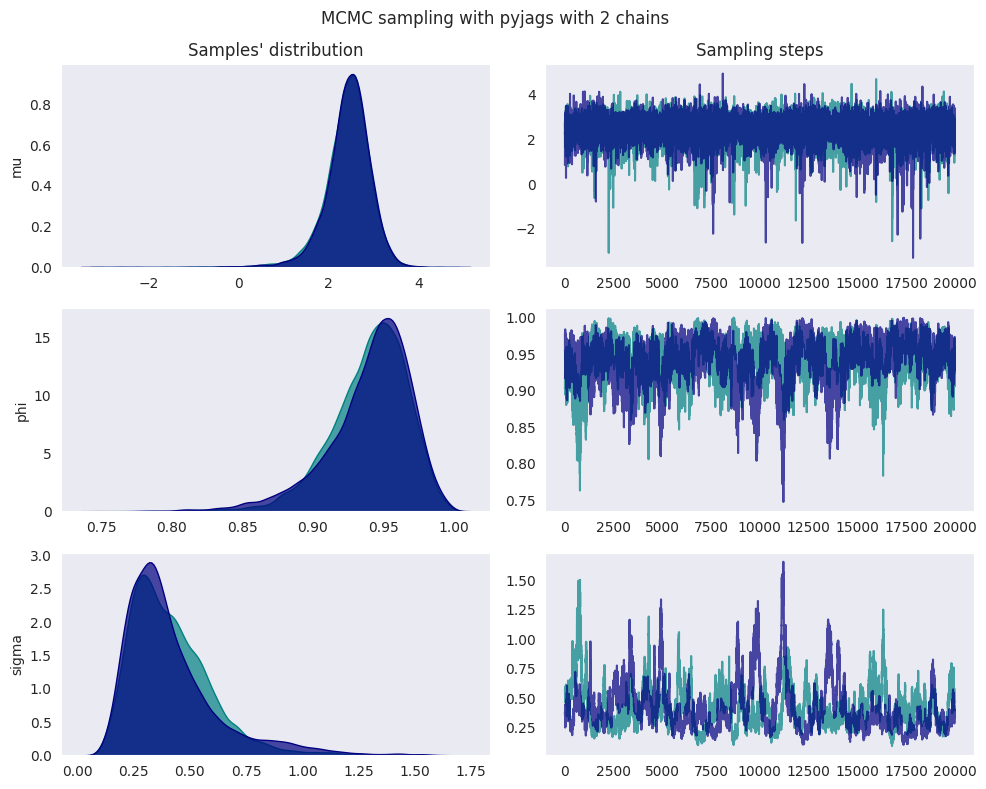

In [143]:
# plots

fig, axs = plt.subplots(len(parameters), 2, figsize=(10, 8))
axs[0, 0].set_title('Samples\' distribution')
axs[0, 1].set_title('Sampling steps')

for p in range(len(parameters)):

  for c in range(CHAINS):
    # samples' distribution
    sns.kdeplot(data=sample_chains[p][BURN_IN:, c], ax=axs[p, 0], color=colors[c], fill=True, alpha=0.7)
    # sampling steps
    sns.lineplot(data=sample_chains[p][BURN_IN:, c], ax=axs[p, 1], color=colors[c], alpha=0.7)

  # axs[p, 0].set_facecolor('black')
  axs[p, 0].set_ylabel(parameters[p])
  # axs[p, 1].set_facecolor('black')

fig.suptitle(f'MCMC sampling with pyjags with {CHAINS} chains')
plt.tight_layout()
plt.show()